**Getting Started with Hugging Face Library: NLP Tasks using Transformers**¶

This notebook serves as a beginner-friendly guide to using the Hugging Face library for natural language processing (NLP) tasks using Transformers. The Hugging Face library provides a wide range of pre-trained models and tools that enable developers to quickly implement state-of-the-art NLP techniques.

This notebook has been created as part of the Lazy Programmer course on transformers, which focuses on practical implementation and understanding of NLP tasks using Hugging Face. Whether you are a beginner or have some experience in NLP, this notebook will help you get started with Transformers and gain hands-on experience with different NLP tasks.

In this notebook, I will cover six essential NLP tasks: sentiment analysis, text generation, masked language modeling, text summarization, question answering and zero-shot classification. For each task, I will walk through the process of importing a dataset, loading a pre-trained Transformer model, and applying the model to the dataset. Do check out this course on Transformers by Lazy programmer for more detailed explanation

**Table of Contents**
- Sentiment Analysis
- Text Generation
- Masked Language Modelling
- Text Summarization
- Question Answering
- Zero-shot Classification

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from transformers import pipeline

import torch


# **Sentiment Analysis**

In this section, we will explore sentiment analysis using a pre-trained Transformer model. The Hugging Face library provides a convenient pipeline function that allows us to easily perform sentiment analysis on text.

First, we import the necessary dependencies and create a sentiment analysis pipeline using pipeline("sentiment-analysis"). This pipeline utilizes a pre-trained Transformer model specifically designed for sentiment analysis tasks.

In [ ]:
classifier = pipeline("sentiment-analysis")
type(classifier)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

transformers.pipelines.text_classification.TextClassificationPipeline

**We can then pass a single sentence or a list of sentences to the classifier and get the predicted sentiment labels and associated confidence scores.**

In [ ]:
# Output is a dictionary containing label and score as keys
classifier("This is a great movie")

[{'label': 'POSITIVE', 'score': 0.9998798370361328}]

In [ ]:
classifier(["This is a irrelevant movie","People of this state are helpful"])

[{'label': 'NEGATIVE', 'score': 0.9997994303703308},
 {'label': 'POSITIVE', 'score': 0.9995457530021667}]

In [ ]:
torch.cuda.is_available(), torch.cuda.current_device()

(True, 0)

In [ ]:
classifier = pipeline("sentiment-analysis", device = 0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
airline_tweets = pd.read_csv("/content/Tweets.csv")
airline_tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


To demonstrate sentiment analysis on a dataset, we load the Twitter Airline Sentiment dataset and extract the relevant columns for analysis.

In [ ]:
df = airline_tweets[['airline_sentiment', 'text']]
df.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...


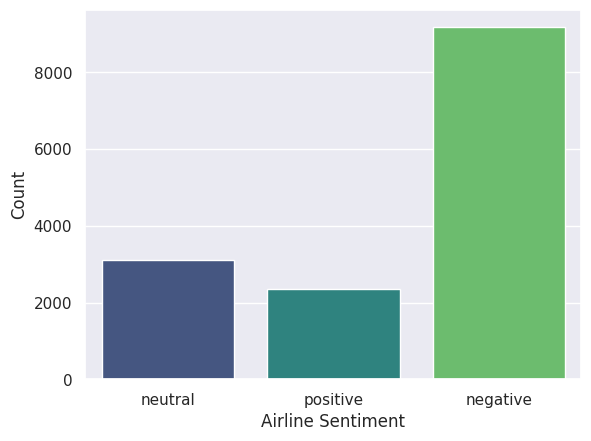

In [ ]:
sns.countplot(df, x = 'airline_sentiment', palette= 'viridis');
plt.xlabel("Airline Sentiment")
plt.ylabel("Count")
plt.show()

*We have 3 classes which do not match the 2 classes available in the hugging face pipeline, therefore we will filter out all the rows which have been labelled as neutral*

In [ ]:
df = df[df['airline_sentiment'] != "neutral"]

In [ ]:
df['target'] = np.where(df['airline_sentiment']=='positive',1,0)
df['target'].value_counts()

0    9178
1    2363
Name: target, dtype: int64

In [ ]:
texts = df['text'].tolist()
predictions = classifier(texts)

In [ ]:
predictions[:5]

[{'label': 'POSITIVE', 'score': 0.6070840954780579},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388}]

In [ ]:
probs = [pred['score'] if pred['label'].startswith('P') else 1 - pred['score'] for pred in predictions]

In [ ]:
preds = np.array([1 if pred['label'].startswith("P") else 0 for pred in predictions])

In [ ]:
print(f"Accuracy: {round(np.mean(df['target'] == preds) * 100, 2)} %")

Accuracy: 88.99 %


In [ ]:
cm = confusion_matrix(df['target'], preds, normalize = 'true')

In [ ]:
def plot_confusion_matrix(confusion_matrix, labels):
    """
    Plot a confusion matrix using Seaborn.

    Args:
        confusion_matrix (np.ndarray): The confusion matrix array.
        labels (list): List of class labels.
    """
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)

    # Create the heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt = 'g', cmap="Blues",
                xticklabels=labels, yticklabels=labels)

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

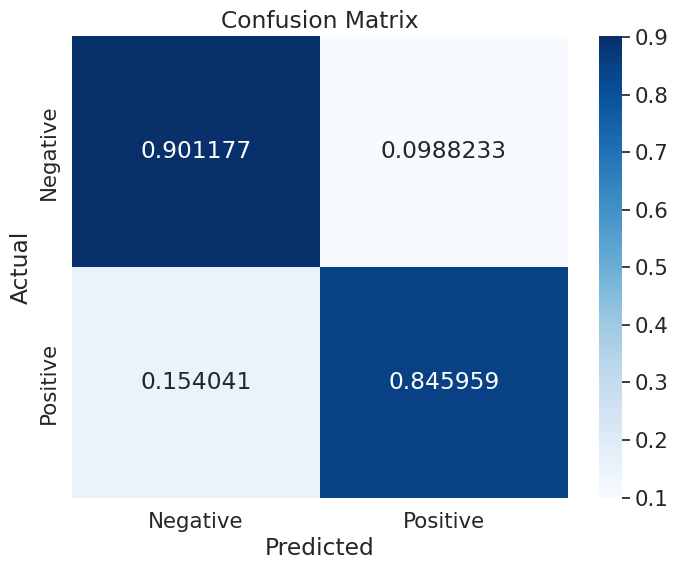

In [ ]:
plot_confusion_matrix(cm, ['Negative', 'Positive'])

In [ ]:
print(f"ROC AUC Score: {roc_auc_score(df['target'], probs)}")

ROC AUC Score: 0.9485934690648773


*With a ROC score of 0.94, we can conclude that the pre-trained sentiment analysis model has achieved a high level of accuracy and effectiveness in predicting sentiment labels. This indicates that the model is capable of accurately classifying text into positive or negative sentiment categories.*

# **Text Generation**

`Text generation involves generating creative and coherent text based on a given prompt or starting point. First, we import the necessary dependencies and load a dataset of poems`

In [ ]:
poems = pd.read_csv("/content/robert_frost_collection.csv")
poems.head()

,Name,Content,Collection,Year of Publication
0,NaN,NaN,NaN,NaN
1,Stopping by Woods on a Snowy Evening,Whose woods these are I think I know. \nHis ...,New Hampshire,1923.0
2,Fire and Ice,"Some say the world will end in fire,\nSome say...",New Hampshire,1923.0
3,The Aim was Song,Before man came to blow it right\nThe wind onc...,New Hampshire,1923.0
4,The Need of Being Versed in Country Things,The house had gone to bring again\nTo the midn...,New Hampshire,1923.0


In [ ]:
content = poems['Content'].dropna().tolist()

In [ ]:
content

['Whose woods these are I think I know.   \nHis house is in the village though;   \nHe will not see me stopping here   \nTo watch his woods fill up with snow.   \nMy little horse must think it queer   \nTo stop without a farmhouse near   \nBetween the woods and frozen lake   \nThe darkest evening of the year.   \nHe gives his harness bells a shake   \nTo ask if there is some mistake.   \nThe only other sound’s the sweep   \nOf easy wind and downy flake.   \nThe woods are lovely, dark and deep,   \nBut I have promises to keep,   \nAnd miles to go before I sleep,   \nAnd miles to go before I sleep.\n',
 'Some say the world will end in fire,\nSome say in ice.\nFrom what I’ve tasted of desire\nI hold with those who favor fire.\nBut if it had to perish twice,\nI think I know enough of hate\nTo say that for destruction ice\nIs also great\nAnd would suffice.\n',
 'Before man came to blow it right\nThe wind once blew itself untaught,\nAnd did its loudest day and night\nIn any rough place where

`To generate text, we extract individual lines from the poems and use the pipeline("text-generation") function to create a text generation pipeline:`

In [ ]:
lines = []

for poem in content:
  for line in poem.split("\n"):
    lines.append(line.rstrip())

In [ ]:
lines = [line for line in lines if len(line) > 0]
lines[:5]

['Whose woods these are I think I know.',
 'His house is in the village though;',
 'He will not see me stopping here',
 'To watch his woods fill up with snow.',
 'My little horse must think it queer']

In [ ]:
gen = pipeline("text-generation")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
lines[0]

'Whose woods these are I think I know.'

`We can then generate text by providing a prompt and specifying parameters such as max_length and num_return_sequences. For example:`

In [ ]:
print(gen(lines[0],max_length = 40))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Whose woods these are I think I know. How much more I know where they are. These rocks in the forest I just dug out.\n\nD.G. Hightower\n\n'}]


In [ ]:
gen(lines[1], max_length = 30, num_return_sequences = 2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'His house is in the village though; there are many children who are of this house with us, that we could not have them without him, because'},
 {'generated_text': "His house is in the village though; but I've seen the whole city in the next weeks, and the first day I arrived there after being informed"}]

In [ ]:
import textwrap
def wrap(x):
    return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

In [ ]:
out = gen(lines[0], max_length = 30)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Whose woods these are I think I know.  Is it any different than their
own?'

'It's just different.  It's all about


In [ ]:
prev = 'Whose woods these are I think I know.  The rest of the forest, a' + \
" little bit, if you'll excuse me.  Just a tiny bit"

In [ ]:
out = gen(prev + '\n' + lines[2], max_length = 60)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Whose woods these are I think I know.  The rest of the forest, a
little bit, if you'll excuse me.  Just a tiny bit
He will not see me
stopping here.   
They will not hear me stop here.  They will not hear
me stop here.


`We can also provide a general prompt to generate text on a specific topic:`

In [ ]:
prompt = "Transformers have a wide variety of applications in NLP like"
out = gen(prompt, max_length = 100)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers have a wide variety of applications in NLP like:

A C++
program to convert images into text, images using CSS, etc…

A C#
program for writing the syntax to convert a file into CSS, etc…

A Web
site for writing a JavaScript web application that is written in Java.
JavaScript programs (including the OJScript language, C#, etc) that
are written in HTML, CSS, JavaScript, or JScript, and


# Masked Language Modelling

*Masked Language Modelling involves predicting masked words within a sentence using pre-trained Transformer models. I am using the BBC text document dataset for this task.*